# Learnings

1. Costs due to rerouting through metro are significant at high levels, but also moderately change the character of upper bounds. Indeed, we observe a nontrivial optimum adoption level in the linear approximation, which we do not observe for the unconstrained version. 
2. However, we observe relatively similar spatial distributions of where adoption campaigns might want to prioritize. 

# Questions

## Single-Layer Effects

1. How much time is spent in congestion, over and above free flow travel time?
2. What is the theoretical best-case cost-benefit curve for removing congestion from the streets, assuming that these drivers can be placed on public transportation 'for free'? 

## Multiplex Effects

1. What is the theoretical best-case cost-benefit curve for removing congestion from the streets, assuming that the relevant drivers drive to and from the metro? 
2. How much flow passes through the metro segments in such a scenario?
3. What is the impact on congestion dynamics on the street network? 

In [5]:
# Get setup

# preferences across the notebook
import warnings                 # suppress ipython warnings
warnings.filterwarnings('ignore') # stops ipython from printing warnings

# Technical, needed to avoid device problems on work server
import matplotlib
matplotlib.use('Agg')

#plots in the doc
% matplotlib inline 

# homebrewed modules
from metro import io            # for reading multiplex
from metro import utility       # for manipulating multiplex
from metro import analysis      # analytical functions
from metro import viz           # for bubble_plot()
from metro import assignment    # for reading and manipulating OD data

# other modules
import networkx as nx           # assigning attributes to multiplex
import matplotlib.pyplot as plt # convenience for plotting
import seaborn as sns           # main plotting library
from matplotlib import pylab    # for colormap manipulation
import numpy as np              # math functions
import pandas as pd

sns.set_style("white") # nicer background style


# Data prep

In [6]:
# read multiplex
multi = io.read_multi() # read the prepared multiplex from 2_multiplex/
# add gradient attribute to edges
gradient = {(e[0],e[1]) : analysis.congestion_gradient(multi.G.edge[e[0]][e[1]]['free_flow_time_m'],
                                                   multi.G.edge[e[0]][e[1]]['flow'],
                                                   multi.G.edge[e[0]][e[1]]['capacity']) for e in multi.G.edges_iter()}
nx.set_edge_attributes(multi.G, 'gradient', gradient)

try: 
    street_grad = pd.read_csv('3_throughput/congestion_w_metro_cache.csv')
except IOError:
    
   
    
    # compute main summary tables
    street_grad = analysis.street_gradients(multi)
    to_metro = analysis.to_metro_gradients(multi)
    
    # Joining and cleaning
    metro_gradient = to_metro[['taz','gradient']].set_index('taz').T.to_dict('records')[0]
    street_grad['o_metro_gradient'] = street_grad.o.map(metro_gradient.get)
    street_grad['d_metro_gradient'] = street_grad.d.map(metro_gradient.get)
    street_grad['net_gradient'] = street_grad['gradient'] - street_grad['o_metro_gradient'] - street_grad['d_metro_gradient']
    street_grad = street_grad.sort_values('net_gradient', ascending = False)
    
    # read OD dict and join to main table
    od = assignment.od_dict(multi.G, '1_data/taz_od/0_1.txt', pivot = False)
    street_grad = street_grad.merge(od)
    street_grad['impact'] = street_grad['flow_norm'] * street_grad['gradient']
    street_grad['net_impact'] = street_grad['flow_norm'] * street_grad['net_gradient']
    street_grad.to_csv('3_throughput/congestion_w_metro_cache.csv')

## Avoidable Congestion

In [7]:
streets = multi.layers_as_subgraph(['streets'])
congestion = [streets.edge[e[0]][e[1]]['flow']*streets.edge[e[0]][e[1]]['congested_time_m'] for e in streets.edges_iter()]
tot_congestion = sum(congestion)

free_flow = [streets.edge[e[0]][e[1]]['flow']*streets.edge[e[0]][e[1]]['free_flow_time_m'] for e in streets.edges_iter()]
tot_free_flow = sum(free_flow)

# % of overall travel time due to congestion (i.e. potentially reducible)
(tot_congestion - tot_free_flow) / tot_congestion

0.24344773369387068

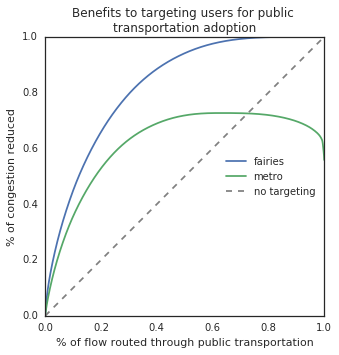

In [8]:
plt.figure(figsize = (5,5))

street_grad = street_grad.sort_values('gradient', ascending = False)
plt.plot(street_grad.flow_norm.cumsum() / sum(street_grad.flow_norm), street_grad.impact.cumsum() / sum(street_grad.impact), label = 'fairies')


street_grad = street_grad.sort_values('net_gradient', ascending = False)
plt.plot(street_grad.flow_norm.cumsum() / sum(street_grad.flow_norm), street_grad.net_impact.cumsum() / sum(street_grad.impact), label = 'metro')

plt.plot([0,1],[0,1], color = 'grey', linestyle = '--', label = 'no targeting')

plt.gca().set(xlabel = '% of flow routed through public transportation', 
             ylabel = '% of congestion reduced',
             title = 'Benefits to targeting users for public \ntransportation adoption')

plt.legend(loc = 'center right')
plt.show()

So, this gives us a **theoretical upper bound** on the returns we could see to routing drivers through public transportation. Assuming we could transport them 'for free', we would be unlikely to do better than this curve. However, this curve seems like a VERY generous upper bound, so I'm not sure how valuable this is. 

Remember also that the impact is just on congested travel time. In particular, 100% on this chart means reducing travel time by roughly 25% overall for those remaining on the street network. 

# Mapping Gradients

In [9]:
def wavg_constructor(col, weight):
    def wavg(group):
        d = group[col]
        w = group[weight]
        return (d * w).sum() / w.sum()
    return wavg

In [10]:
wavg = wavg_constructor('gradient', 'flow_norm')
x = street_grad.groupby('o').apply(wavg)
y = street_grad.groupby('o').sum()['flow_norm']
df = pd.DataFrame({'o' : x.index, 'gradient' : x, 'demand' : y})
df = df.set_index('o')
df = df.to_dict()

nx.set_node_attributes(multi.G, 'o_gradient', 0)
nx.set_node_attributes(multi.G, 'o_demand', 0)
nx.set_node_attributes(multi.G, 'o_gradient', df['gradient'])
nx.set_node_attributes(multi.G, 'o_demand', df['demand'])

wavg = wavg_constructor('net_gradient', 'flow_norm')
x = street_grad.groupby('o').apply(wavg)
y = street_grad.groupby('o').sum()['flow_norm']
df = pd.DataFrame({'o' : x.index, 'net_gradient' : x, 'demand' : y})
df = df.set_index('o')
df = df.to_dict()

nx.set_node_attributes(multi.G, 'o_net_gradient', 0)
nx.set_node_attributes(multi.G, 'o_net_gradient', df['net_gradient'])


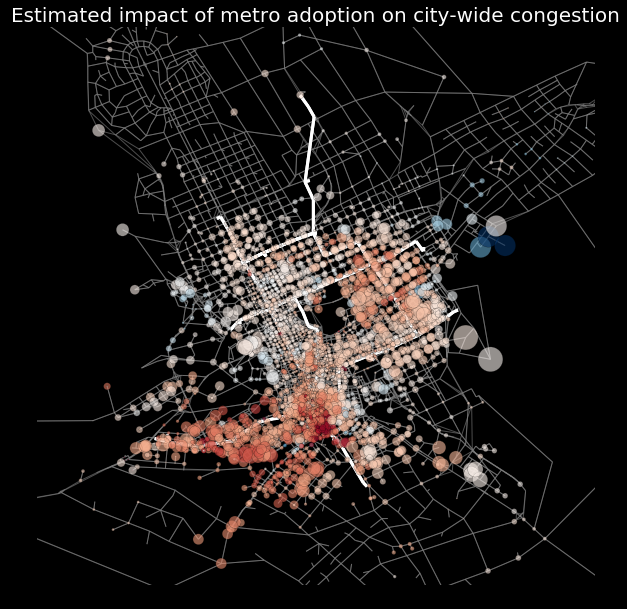

In [54]:
G = multi.G # pull G for plotting functions

# create the figure

xlim = (46.4167, 47.0167)
ylim = (24.4333, 25.0333)
fig = plt.figure(figsize = (10,10), dpi = 500)

ax = fig.add_subplot(111)
viz.bubble_plot(G, size = 'o_demand', color = 'o_net_gradient' , size_factor = 0.05, vmin = -15, vmax = 15, cmap = 'RdBu_r', alpha = .6)
ax.set(xlim = xlim, ylim = ylim)
plt.title(r'Estimated impact of metro adoption on city-wide congestion', 
              color = 'w', 
              fontsize = 20)

metro = multi.layers_as_subgraph(['metro'])
metro.position = {n : (metro.node[n]['lon'], metro.node[n]['lat']) for n in metro}
nx.draw_networkx_edges(metro, metro.position, ax = ax, width = 3, edge_color = 'white', arrows = False)

fig.set_facecolor("#000000")

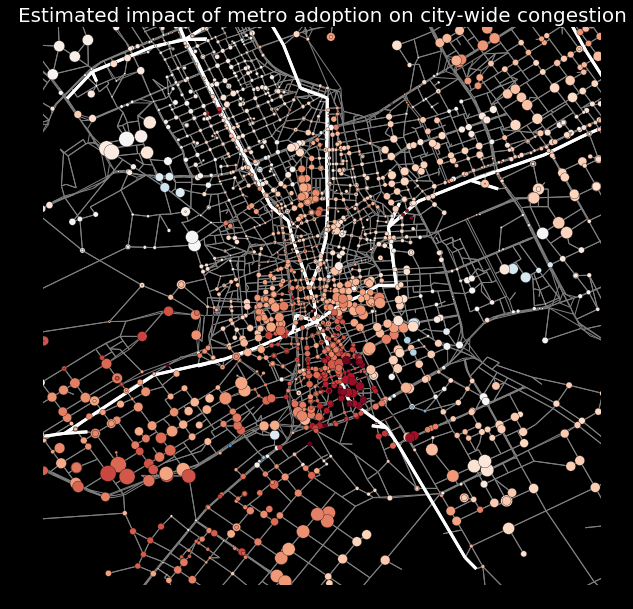

In [53]:
xlim = (46.6167, 46.8167)
ylim = (24.5333, 24.7333)
fig = plt.figure(figsize = (10,10), dpi = 500)

ax = fig.add_subplot(111)
viz.bubble_plot(G, size = 'o_demand', color = 'o_net_gradient' , size_factor = 0.05, 
                vmin = -15, vmax = 15, cmap = 'RdBu_r', alpha = 1)
ax.set(xlim = xlim, ylim = ylim)
plt.title(r'Estimated impact of metro adoption on city-wide congestion', 
              color = 'w', 
              fontsize = 20)

metro = multi.layers_as_subgraph(['metro'])
metro.position = {n : (metro.node[n]['lon'], metro.node[n]['lat']) for n in metro}
nx.draw_networkx_edges(metro, metro.position, ax = ax, width = 3, edge_color = 'white', arrows = False)

fig.set_facecolor("#000000")

Next steps: 

- Clean up the writing on this one, and more explicitly link it to the previous notebook. 
- Work on user equilibrium routing
- Check in with Zeyad's progress